In [5]:
!pip install -q opendatasets
import opendatasets as od
# mendownload dataset dari kaggle menggunakan opendatasets
od.download('https://www.kaggle.com/datasets/emmanuelfwerr/london-weather-data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lutfihida
Your Kaggle Key: ··········


100%|██████████| 226k/226k [00:00<00:00, 50.4MB/s]

In [6]:
# import library
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [7]:
# mengubah dataset menjadi pandas dataframe
df = pd.read_csv('/content/london-weather-data/london_weather.csv')

df.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


In [8]:
# Output jumlah sampel dataset
print(f'Jumlah sampel dataset {len(df)}')

Jumlah sampel dataset 15341


In [9]:
# Output jumlah data dengan value null
df.isnull().sum()

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64

In [10]:
# isi data yang bernilai null dengan value setelahnya
df.fillna(method='ffill', inplace=True)
df.isnull().sum()

date                0
cloud_cover         0
sunshine            0
global_radiation    0
max_temp            0
mean_temp           0
min_temp            0
precipitation       0
pressure            0
snow_depth          0
dtype: int64

In [11]:
# normalisasi data
scaler = MinMaxScaler()
X_data = scaler.fit_transform(df.iloc[:, 1:].values)
X_data

array([[0.22222222, 0.4375    , 0.11167513, ..., 0.00647249, 0.67042889,
        0.40909091],
       [0.66666667, 0.10625   , 0.04822335, ..., 0.        , 0.74153499,
        0.36363636],
       [0.55555556, 0.        , 0.01269036, ..., 0.        , 0.68735892,
        0.18181818],
       ...,
       [0.77777778, 0.        , 0.03299492, ..., 0.        , 0.32392777,
        0.        ],
       [0.66666667, 0.025     , 0.03553299, ..., 0.        , 0.4785553 ,
        0.        ],
       [0.77777778, 0.08125   , 0.06598985, ..., 0.        , 0.51241535,
        0.        ]])

In [24]:
# fitur yang akan digunakan
df.columns[3]

'global_radiation'

In [12]:
# extract x dan y yang akan digunakan dari df
dates = df['date'].values
radiation  = X_data[:, 3]

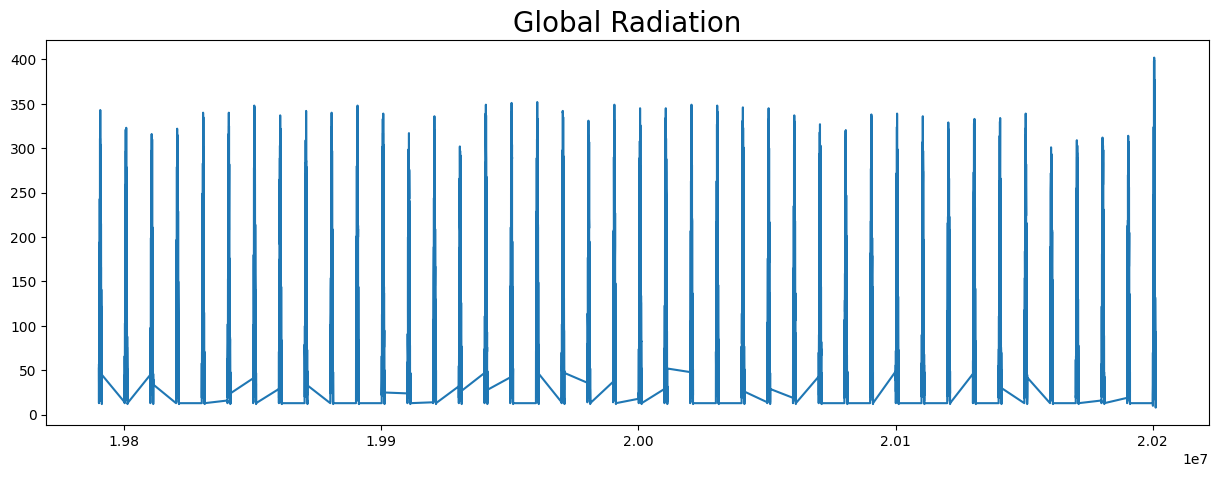

In [26]:
# Plot global radiation (tanpa normalisasi)
plt.figure(figsize=(15,5))
plt.plot(dates, df['global_radiation'])
plt.title('Global Radiation',
          fontsize=20);

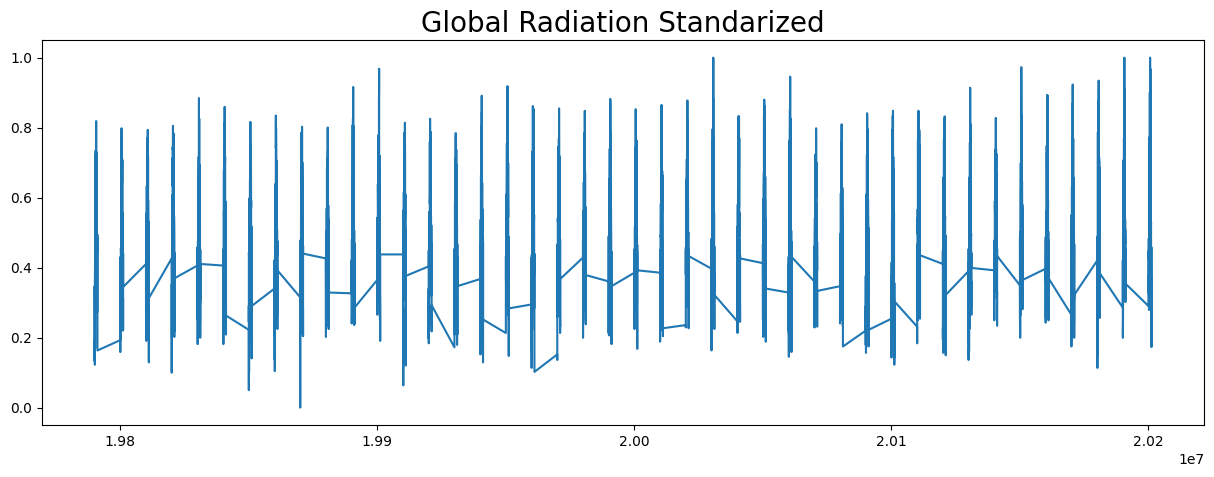

In [27]:
# Plot global radiation (dengan normalisasi)
plt.figure(figsize=(15,5))
plt.plot(dates, radiation)
plt.title('Global Radiation Standarized',
          fontsize=20);

In [14]:
# Membagi dataset
X_train, X_test, y_train, y_test = train_test_split(radiation, dates,
                                               test_size=0.2,
                                               shuffle=False)
print(len(X_train), len(X_test))

12272 3069


In [15]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [73]:
train_set = windowed_dataset(X_train, window_size=64, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(X_test, window_size=64, batch_size=100, shuffle_buffer=1000)

# Model
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [74]:
# menentukan threshold mae (6.5% dari skala data/di bawah 10%)
threshold_mae = (radiation.max() - radiation.min()) * 6.5/100
threshold_mae

0.065

In [75]:
# membuat custom callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < threshold_mae and logs.get('val_mae') < threshold_mae): # stop ketika mae dan val_mae di bawah threshold
      print("MAE di bawah threshold!")
      self.model.stop_training = True
callbacks = myCallback()

In [76]:
# compile model
optimizer = tf.keras.optimizers.Nadam(learning_rate=1.0000e-04) # menggunakan optimizer nadam dengan leaerning rate 0.0001
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [77]:
# melatih dan menguji model
history = model.fit(train_set,
                    epochs=80,
                    callbacks=[callbacks],
                    validation_data=test_set,
                    verbose=2
                    )

Epoch 1/80
123/123 - 11s - loss: 0.0449 - mae: 0.2292 - val_loss: 0.0038 - val_mae: 0.0673 - 11s/epoch - 88ms/step
Epoch 2/80
123/123 - 3s - loss: 0.0049 - mae: 0.0777 - val_loss: 0.0034 - val_mae: 0.0633 - 3s/epoch - 25ms/step
Epoch 3/80
123/123 - 3s - loss: 0.0042 - mae: 0.0726 - val_loss: 0.0033 - val_mae: 0.0621 - 3s/epoch - 24ms/step
Epoch 4/80
123/123 - 4s - loss: 0.0038 - mae: 0.0684 - val_loss: 0.0031 - val_mae: 0.0606 - 4s/epoch - 32ms/step
Epoch 5/80
123/123 - 4s - loss: 0.0036 - mae: 0.0665 - val_loss: 0.0037 - val_mae: 0.0657 - 4s/epoch - 33ms/step
Epoch 6/80
123/123 - 3s - loss: 0.0033 - mae: 0.0639 - val_loss: 0.0045 - val_mae: 0.0742 - 3s/epoch - 24ms/step
Epoch 7/80
123/123 - 3s - loss: 0.0033 - mae: 0.0637 - val_loss: 0.0048 - val_mae: 0.0769 - 3s/epoch - 27ms/step
Epoch 8/80
123/123 - 4s - loss: 0.0031 - mae: 0.0625 - val_loss: 0.0040 - val_mae: 0.0692 - 4s/epoch - 33ms/step
Epoch 9/80
123/123 - 3s - loss: 0.0030 - mae: 0.0615 - val_loss: 0.0050 - val_mae: 0.0796 - 3s

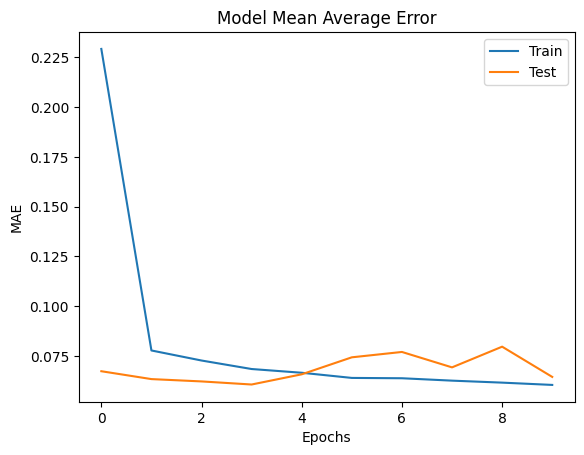

In [78]:
# Plot accuracy/MAE model
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Average Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(['Train', 'Test'])
plt.show()

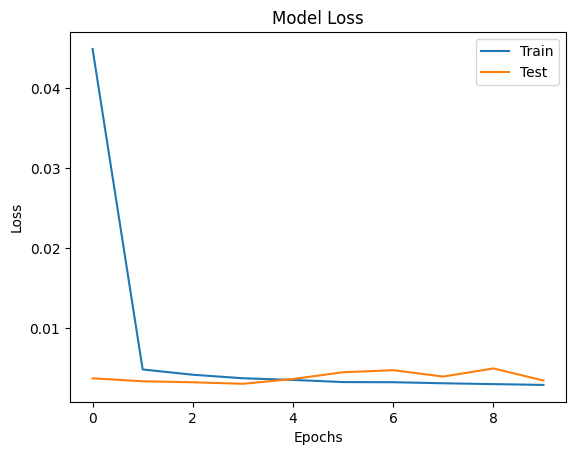

In [79]:
# Plot loss model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()